In [58]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np

In [59]:
importpath = r'C:\Users\nmur1\Google Drive\Springboard\Capstone2\CleanData'
os.chdir(importpath)

#import datasets from cleaning
quant = 'Historical Quant Prices.csv'
df = pd.read_csv(quant).drop(columns = 'Unnamed: 0')
df.shape

(560859, 36)

In [60]:
try:
    df.drop(columns = 'Direction', inplace = True)
except:
    pd.DataFrame(df.columns)



In [61]:
#classify column 'D'
#Column D measures the 7 day future price change for a given company
#-1 if change is less than 1%, +1 if change is greater than 1%, 0 otherwise
def classifier_binary(x):
    if x < 0:
        return 0
    else:
        return 1
  

def classifier_multi(x):
    if x < -.01:
        return -1
    elif x > .01:
        return 1
    else:
        return 0


df['Dir_Binary'] = df['D'].apply(classifier_binary)
df['Dir_Multi']  = df['D'].apply(classifier_multi)
#df = df.drop(columns = ['D', 'Direction'])

In [62]:
pd.options.display.float_format = '{:.4f}'.format
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Close,560859.0000,114.9364,191.1610,0.0050,45.8300,75.9900,124.6600,4037.7700
DI_Plus,560859.0000,23.7753,7.5348,1.1011,18.4747,23.3756,28.5493,100.0000
DI_Neg,560859.0000,22.4486,7.9209,0.0000,16.7378,21.6584,27.3099,70.7301
ADX,560859.0000,24.1795,9.7968,3.5298,16.7945,22.2064,29.6887,77.2602
DI_Neg_Slope,560859.0000,-0.0038,1.1427,-8.9693,-0.7695,-0.1623,0.5855,10.7077
DI_Plus_Slope,560859.0000,0.0029,1.1135,-5.7030,-0.7501,-0.0887,0.6645,9.6123
SMA,560859.0000,114.4097,189.6207,0.0294,45.8144,75.7890,124.0275,3941.5925
UpperB,560859.0000,120.7456,200.8334,0.0435,48.3467,79.5762,130.4560,4691.4898
LowerB,560859.0000,108.0738,178.8879,-74.5727,43.1332,71.8486,117.5221,3795.5463
Off_SMA,560859.0000,0.3304,6.0765,-92.9028,-1.7569,0.6410,2.8055,1847.9206


In [63]:
#this function allows me to inspect outlier summary stats before actually removing them
#After my initial analysis I found that Age at IPO, GDP Growth, and 

def Outlier_Summary(df):
    
    lstoutlier = []
    #create dataframe with only numbers
    NuDF = df.select_dtypes(include=['int64', 'float64'])
   
    for col in NuDF:
    
    
        df1 = NuDF[[col]]
         #get first quartile
        Q1 = df1.quantile(.25)

        #get second quartile 
        Q3 = df1.quantile(.75)
    
        # Now calculate the IQR, storing it in a variable called IQR.
        IQR = Q3 - Q1
    
        #filter outliers
        outliers = df1[((df1 < (Q1 - 1.5 * IQR)) |(df1 > (Q3 + 1.5 * IQR)))]
        cnt = pd.DataFrame(outliers[outliers[col].notnull()].count())
        cnt.columns = ['Outliers']
        
        
        
        #outliers = pd.melt(outliers, var_name = 'Field')
        cnt['IQR'] = NuDF[col].quantile(.75) - NuDF[col].quantile(.25)
        cnt['Mean'] = NuDF[col].mean()
        cnt['PercentOutlier'] = cnt.Outliers/len(df) * 100
        lstoutlier.append(cnt)
        
        
    return  pd.concat(lstoutlier)
                    
    #dfOutlier = pd.DataFrame(lstoutlier)
test = Outlier_Summary(df)

test

,Outliers,IQR,Mean,PercentOutlier
Close,39495,78.8300,114.9364,7.0419
DI_Plus,5510,10.0746,23.7753,0.9824
DI_Neg,7001,10.5721,22.4486,1.2483
ADX,11578,12.8942,24.1795,2.0643
DI_Neg_Slope,16742,1.3550,-0.0038,2.9851
DI_Plus_Slope,9950,1.4146,0.0029,1.7741
SMA,39658,78.2131,114.4097,7.0709
UpperB,40320,82.1094,120.7456,7.1890
LowerB,38823,74.3889,108.0738,6.9221
Off_SMA,33006,4.5624,0.3304,5.8849


In [64]:
Q1 = df.quantile(.25)

# Now get Q3 and store in a variable called Q3. 
Q3 = df.quantile(.75)
# Now calculate the IQR, storing it in a variable called IQR.
IQR = Q3 - Q1


# Make a variable called `dfno`, and assign it the value: df[~((df < (Q1 - 1.5 * IQR)) |(df> (Q3 + 1.5 * IQR))).any(axis=1)]. 
# This filters on our existing dataframe, picking out just those observations that are NOT outliers. 

dfno = df[~((df < (Q1 - 1.5 * IQR)) |(df> (Q3 + 1.5 * IQR))).any(axis=1)]

In [65]:
def remove_outlier(df, f):
    
    #for f in fields:
        
        Q1 = df[f].quantile(.25)
        Q3 = df[f].quantile(.75)
        IQR =Q3 - Q1
        
        #df['Upper'] = Q1 * 1.5 * IQR 
        
        #df['Lower'] = Q1 * 1.5 * IQR 
        dfnox = df[~((df[f] < (Q1 - 1.5 * IQR)) |(df[f]> (Q3 + 1.5 * IQR))).any(axis = 1)]
        return dfnox
    

outlier1 = remove_outlier(df, ['Relative_SR', 'Relative_PE'] )

In [66]:

nooutliers = remove_outlier(df, ['Relative_PE'] )
nooutliers2 =remove_outlier(df, ['PE_Ratio', 'Sales_Ratio'] )
nooutliers3 = remove_outlier(df, ['Sales_Ratio'] )

In [67]:
def splot(df, glevel1, glevel2, field1, field2):
    df1 = pd.DataFrame(df.groupby([glevel1, glevel2])[field1].mean()).reset_index()
    df2 = pd.DataFrame(df.groupby([glevel1, glevel2])[field2].mean()).reset_index()
    df2 = df2[field2]
    df3 = pd.concat([df1,df2], axis = 1)

    Q1 = df3.quantile(.25)
    Q3 = df3.quantile(.75)
    # Now calculate the IQR, storing it in a variable called IQR.
    IQR = Q3 - Q1


    # Make a variable called `dfno`, and assign it the value: df[~((df < (Q1 - 1.5 * IQR)) |(df> (Q3 + 1.5 * IQR))).any(axis=1)]. 
    # This filters on our existing dataframe, picking out just those observations that are NOT outliers. 

    dfno2 = df3[~((df3 < (Q1 - 1.5 * IQR)) |(df3> (Q3 + 1.5 * IQR))).any(axis=1)]
    #print(dfno2.Year.value_counts())
    ax = sns.scatterplot(x=field1, y=field2, hue = 'Year',
                         data=dfno2)

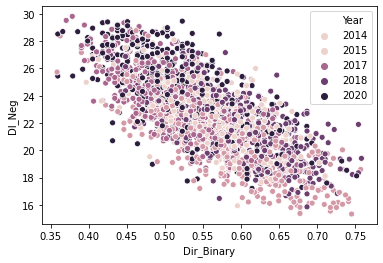

In [68]:
splot(df, 'Ticker', 'Year', 'Dir_Binary', 'DI_Neg')

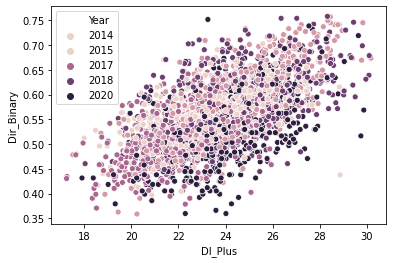

In [69]:
splot(df, 'Ticker', 'Year', 'DI_Plus', 'Dir_Binary')

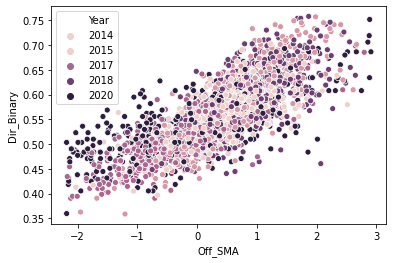

In [70]:
splot(df, 'Ticker', 'Year', 'Off_SMA', 'Dir_Binary')

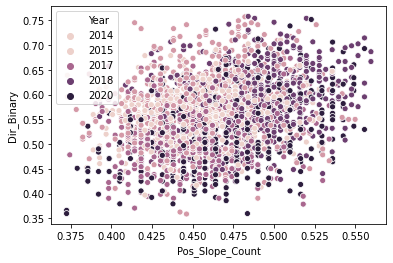

In [71]:
dftemp = df
dftemp['Pos_Slope_Count']  = (dftemp.DI_Plus_Slope > 0) * 1

splot(dftemp, 'Ticker', 'Year', 'Pos_Slope_Count', 'Dir_Binary')

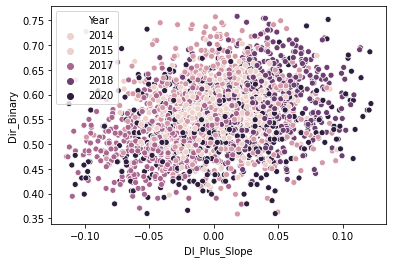

In [72]:
splot(df, 'Ticker', 'Year', 'DI_Plus_Slope', 'Dir_Binary')

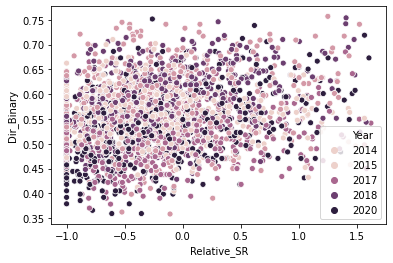

In [73]:
splot(df, 'Ticker', 'Year', 'Relative_SR', 'Dir_Binary')

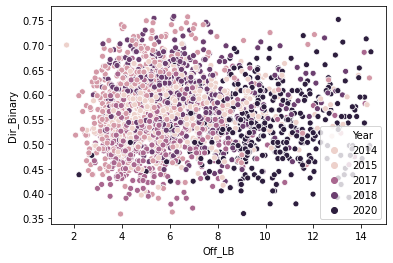

In [75]:
splot(df, 'Ticker', 'Year', 'Off_LB', 'Dir_Binary')

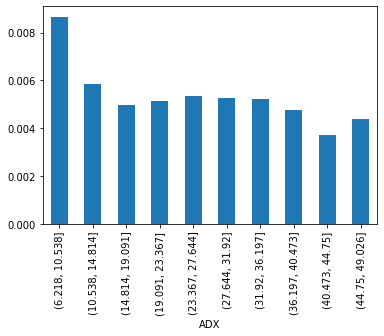

In [76]:
def plotbin(df, binfield, bins):
    bins = pd.DataFrame(pd.cut(df[binfield],bins = 10))
    binplot = pd.concat([bins, df[['D']]], axis = 1)
    #pd.DataFrame(binplot.groupby(binfield)['Dir_Binary'].mean()).to_clipboard()
    binplot.groupby(binfield)['D'].mean().plot(kind = 'bar')

plotbin(dfno, 'ADX', 20)